In [1]:
import numpy as np
import pickle
import torch
from torch_geometric.data import Batch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GatedGraphConv, AttentionalAggregation
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [4]:
graphs = []
for adsorbate in ['OCH3samlet', 'COsamlet', 'OHsamlet', 'MCsamlet']:
    # Load the data from the file
    with open(f'{adsorbate}.graphs', 'rb') as input_file:
        graphs += pickle.load(input_file)

# Shuffle the graphs to ensure randomness
random.shuffle(graphs)

# Define the split ratios (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of graphs for each split
num_graphs = len(graphs)
num_train = int(train_ratio * num_graphs)
num_val = int(val_ratio * num_graphs)
num_test = num_graphs - num_train - num_val

# Split the data
train_data = graphs[:num_train]
val_data = graphs[num_train:num_train + num_val]
test_data = graphs[num_train + num_val:]

# Example usage:
print("Number of graphs in train set:", len(train_data))
print("Number of graphs in validation set:", len(val_data))
print("Number of graphs in test set:", len(test_data))



Number of graphs in train set: 2192
Number of graphs in validation set: 469
Number of graphs in test set: 471


In [5]:
# GCN
num_hidden = 24 #dobbelt af features
num_gated_layers = 3
num_lin_layers = 1
dropout = 0.5

# Parameters
num_epochs = 75
lr = 0.001
batch_size = 32

class GCN(torch.nn.Module):
    def __init__(self, num_hidden, num_gated_layers, num_lin_layers, dropout):
        super(GCN, self).__init__()
        
        self.num_lin_layers = num_lin_layers
        self.dropout = dropout

        # Gated Graph convolution
        self.gated_conv = GatedGraphConv(out_channels=num_hidden, num_layers=num_gated_layers) 

        self.att = AttentionalAggregation(torch.nn.Linear(num_hidden, 1))

        # Define the GCN layers
        self.lin = torch.nn.ModuleList()
        for _ in range(num_lin_layers - 1):
            self.lin.append(torch.nn.Linear(num_hidden, num_hidden))
        self.lin.append(torch.nn.Linear(num_hidden, 1))

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Pass input through gated convolution
        x = self.gated_conv(x, edge_index)

        # Attentional Aggregation
        x = self.att(x, batch)

        # Pass the input through the GCN layers
        for i in range(self.num_lin_layers - 1):
            x = self.lin[i](x)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout)
   
        # Pass through the final layer
        x = self.lin[-1](x)
        
        return x
    
    def load_state(self,name):
        self.load_state_dict(torch.load(name))

def train(model, loader, optimizer, criterion):
    model.train()
    loss_accum = 0
    for data in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1), data.y.float())
        loss.backward()
        optimizer.step()
        loss_accum += loss.item() * data.num_graphs
    return loss_accum / len(loader.dataset)


def evaluate(model, loader, criterion):
    model.eval()
    loss_accum = 0
    with torch.no_grad():
        for data in loader:
            output = model(data)
            loss = criterion(output.view(-1), data.y.float())
            loss_accum += loss.item() * data.num_graphs
    return loss_accum / len(loader.dataset)




Epoch: 1, Train Loss: 0.8196, Val Loss: 0.8221
Epoch: 2, Train Loss: 0.8113, Val Loss: 0.8138
Epoch: 3, Train Loss: 0.8100, Val Loss: 0.8226
Epoch: 4, Train Loss: 0.8068, Val Loss: 0.8124
Epoch: 5, Train Loss: 0.8019, Val Loss: 0.8060
Epoch: 6, Train Loss: 0.7997, Val Loss: 0.7904
Epoch: 7, Train Loss: 0.5234, Val Loss: 0.2944
Epoch: 8, Train Loss: 0.2085, Val Loss: 0.1719
Epoch: 9, Train Loss: 0.1513, Val Loss: 0.1370
Epoch: 10, Train Loss: 0.1246, Val Loss: 0.1185
Epoch: 11, Train Loss: 0.1125, Val Loss: 0.1053
Epoch: 12, Train Loss: 0.1054, Val Loss: 0.1116
Epoch: 13, Train Loss: 0.1019, Val Loss: 0.1011
Epoch: 14, Train Loss: 0.0965, Val Loss: 0.1006
Epoch: 15, Train Loss: 0.0986, Val Loss: 0.0935
Epoch: 16, Train Loss: 0.0910, Val Loss: 0.0923
Epoch: 17, Train Loss: 0.0877, Val Loss: 0.0900
Epoch: 18, Train Loss: 0.0868, Val Loss: 0.0958
Epoch: 19, Train Loss: 0.0864, Val Loss: 0.1000
Epoch: 20, Train Loss: 0.0845, Val Loss: 0.0814
Epoch: 21, Train Loss: 0.0803, Val Loss: 0.0879
E

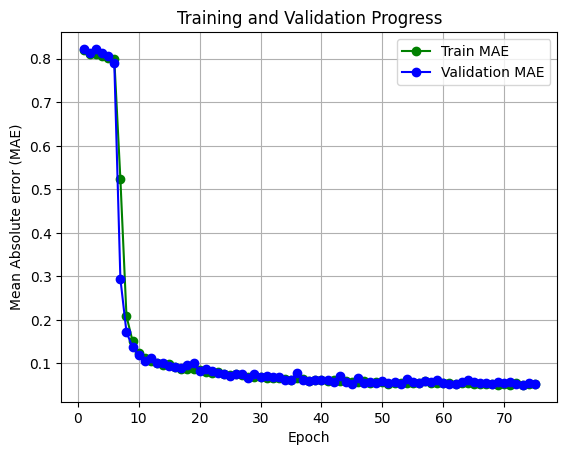

In [7]:
# Initialize model, optimizer, and loss function
model = GCN(num_hidden, num_gated_layers, num_lin_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.L1Loss()

# Validation data loader
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Lists to store epoch and MAE values
epoch_list = []
train_mae_list = []
val_mae_list = []

# Lists to store true and predicted values for best epoch
best_val_true_values = []
best_val_predicted_values = []

# Initialize variables to track best epoch and best validation loss
best_epoch = 0
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Append epoch and MAE values to the lists
    epoch_list.append(epoch+1)
    train_mae_list.append(train_loss)
    val_mae_list.append(val_loss)
    
    # Check if the current epoch has the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_params = deepcopy(model.state_dict())
        
        
        # Reset best_val_true_values and best_val_predicted_values
        best_val_true_values.clear()
        best_val_predicted_values.clear()
        
        # Store true and predicted values for the best epoch
        with torch.no_grad():
            for data in val_loader:
                output = model(data)
                best_val_true_values.extend(data.y.cpu().detach().numpy())
                best_val_predicted_values.extend(output.cpu().detach().numpy().flatten())


# Plotting
plt.plot(epoch_list, train_mae_list, marker='o', label='Train MAE', color='green')
plt.plot(epoch_list, val_mae_list, marker='o', label='Validation MAE', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute error (MAE)')
plt.title('Training and Validation Progress')
plt.legend()
plt.grid(True)
plt.show()
torch.save(best_params, 'alladsgraphs')


